In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier as dtc 
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree


In [205]:
df = pd.read_csv("Match_Information_cleaned.csv")

In [206]:
df.head()

,gameId,gameDuration,gameVersion,platformId,season,winner,1st_baron,1st_dragon,1st_inhibitor,1st_riftHerald,...,t2_baron_kills,t2_champ_kills,t2_dragon_kills,t2_inhibitor_kills,t2_riftHerald_kills,t2_tower_kills,t2_team_assists,t2_team_gold_earn,t2_team_gold_spen,t2_team_kda
0,1245810008,43.0,11.22.406.3587,EUW1,11,2,1,1,2,1,...,2,52,4,5,1,11,58,89056,86000,2.619048
1,1245827001,20.0,11.22.406.3587,EUW1,11,1,0,2,1,1,...,0,25,1,0,1,0,37,39261,37685,1.476190
2,1243137392,33.0,11.22.406.3587,EUW1,11,2,1,2,2,1,...,0,35,4,1,0,7,53,63064,56970,3.259259
3,1243091838,32.0,11.22.406.3587,EUW1,11,2,2,1,2,2,...,2,43,2,5,1,11,66,71984,63978,3.114286
4,770956820,51.0,11.2.353.8505,EUW1,11,1,2,2,1,1,...,1,66,2,1,0,8,93,103306,96280,1.915663


In [207]:
x1 = df[df['winner'] == 1]['gameDuration']

Removing time less than 15 minutes, and less situations based on lol_data_analyse result

In [208]:
df = df[(df['gameDuration'] >= 15.0) & (df['t1_baron_kills'] <= 3) & (df["t1_dragon_kills"] <= 5) & (df["t1_inhibitor_kills"] <= 5)]
df = df[(df['t2_baron_kills'] <= 3) & (df["t2_dragon_kills"] <= 5) & (df["t2_inhibitor_kills"] <= 5)]

In [209]:
df.columns

Index(['gameId', 'gameDuration', 'gameVersion', 'platformId', 'season',
       'winner', '1st_baron', '1st_dragon', '1st_inhibitor', '1st_riftHerald',
       '1st_tower', 't1_baron_kills', 't1_champ_kills', 't1_dragon_kills',
       't1_inhibitor_kills', 't1_riftHerald_kills', 't1_tower_kills',
       't1_team_assists', 't1_team_gold_earn', 't1_team_gold_spen',
       't1_team_kda', 't2_baron_kills', 't2_champ_kills', 't2_dragon_kills',
       't2_inhibitor_kills', 't2_riftHerald_kills', 't2_tower_kills',
       't2_team_assists', 't2_team_gold_earn', 't2_team_gold_spen',
       't2_team_kda'],
      dtype='object')

In [210]:
model_1 = df[['winner','t1_baron_kills', 't1_dragon_kills', 't1_tower_kills',
            't1_inhibitor_kills', 't1_riftHerald_kills','t2_baron_kills','t2_dragon_kills', 
            't2_tower_kills','t2_inhibitor_kills', 't2_riftHerald_kills']]

Using stratified sampling to set 80% data as training set and 20% as testing set

In [211]:
x = model_1.drop('winner', axis=1)
y = model_1['winner']

x_train_set_1, x_test_set_1, y_train_set_1, y_test_set_1 = train_test_split(x, y, test_size=0.2, stratify=y, random_state=4)

x_train_set_1.shape
x_test_set_1.shape

(15413, 10)

(3854, 10)

In [212]:
splitter = ('best', 'random')
criterion = ('gini', 'entropy')
max_depth = [*range(1, 20, 2)]

In [213]:
parameters = {
    'splitter': ('best', 'random'),
    'criterion':('gini', 'entropy'),
    'max_depth':[*range(1, 20, 2)],
}
 
clf = dtc(random_state=4)
model = GridSearchCV(clf, parameters, cv=10)
model.fit(x_train_set_1, y_train_set_1)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})

In [214]:
GridSearchCV(cv=10, estimator=dtc(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'splitter': ('best', 'random')})

In [215]:
model.best_score_
model.best_params_

0.9637318819537904

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}

In [216]:
x_train_set_1.columns

Index(['t1_baron_kills', 't1_dragon_kills', 't1_tower_kills',
       't1_inhibitor_kills', 't1_riftHerald_kills', 't2_baron_kills',
       't2_dragon_kills', 't2_tower_kills', 't2_inhibitor_kills',
       't2_riftHerald_kills'],
      dtype='object')

In [217]:
best_model = dtc(criterion = 'gini', max_depth = 7, splitter = 'best')
best_model.fit(x_train_set_1, y_train_set_1)

pred_model = model.predict(x_test_set_1)


DecisionTreeClassifier(max_depth=7)

In [218]:
imp = pd.DataFrame(list(zip(x_train_set_1.columns, best_model.feature_importances_)))
imp.columns = ['columns', 'importances_score']
imp = imp.sort_values('importances_score', ascending=False)
imp

,columns,importances_score
8,t2_inhibitor_kills,0.592255
2,t1_tower_kills,0.301635
7,t2_tower_kills,0.068786
3,t1_inhibitor_kills,0.009934
6,t2_dragon_kills,0.006289
1,t1_dragon_kills,0.006080
0,t1_baron_kills,0.006080
5,t2_baron_kills,0.005000
9,t2_riftHerald_kills,0.003165
4,t1_riftHerald_kills,0.000775


In [219]:
feature_names = model_1.columns[:15]
target_names = df['winner'].unique().tolist()

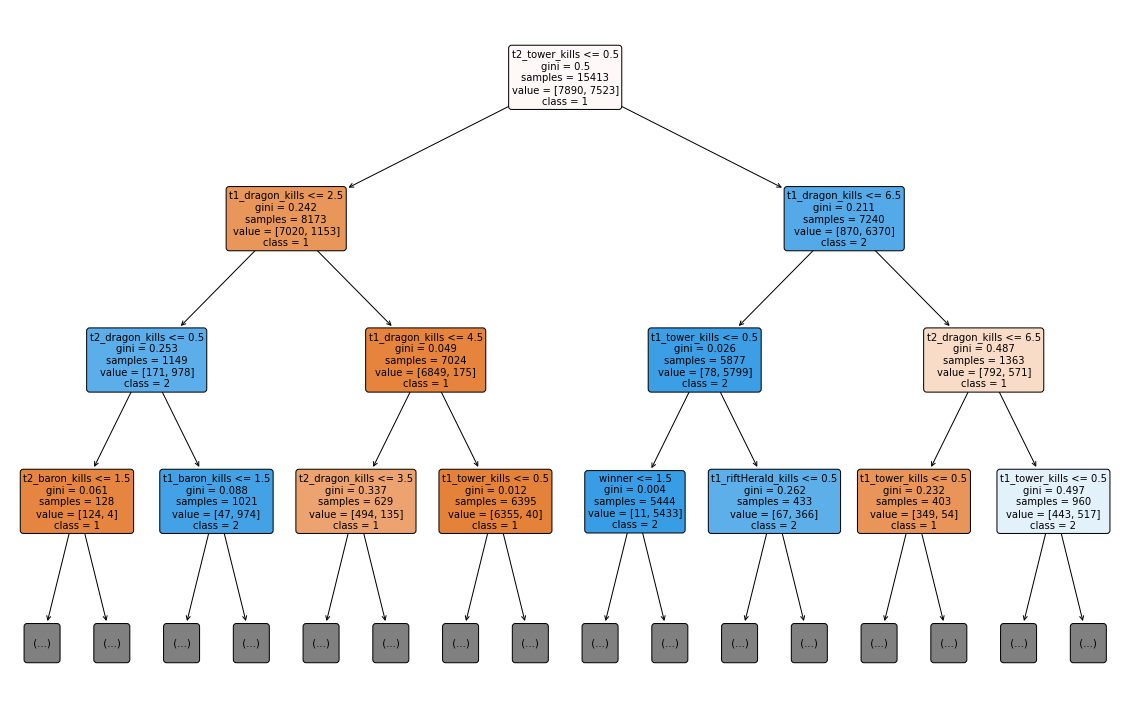

In [220]:
plt.figure(figsize=(20, 13))

doa = plot_tree(best_model, max_depth=3,
            feature_names = feature_names, 
            class_names = ['1', '2'], 
            filled = True, 
            rounded = True, fontsize = 10)


plt.savefig('tree_visualization.png');

In [221]:
model_1.columns

Index(['winner', 't1_baron_kills', 't1_dragon_kills', 't1_tower_kills',
       't1_inhibitor_kills', 't1_riftHerald_kills', 't2_baron_kills',
       't2_dragon_kills', 't2_tower_kills', 't2_inhibitor_kills',
       't2_riftHerald_kills'],
      dtype='object')

In [251]:
new_data = [[1, 1, 10, 2, 1, 4, 1, 0, 0, 1]]
c = best_model.predict_proba(new_data)
print("winner is :" , best_model.predict(new_data))
print("First team win probability is", c[0][0] * 100, "%", "\nSecond team win probability is",c[0][1] * 100, "%")

winner is : [1]
First team win probability is 97.22222222222221 % 
Second team win probability is 2.7777777777777777 %
